In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import calibration_curve

In [3]:
dataset = pd.read_csv('split_4.csv')
dataset

,is_anxious,tweets
0,0,home deal may happen
1,4,would good time break rafa
2,4,feel like got hit baseball bat right back lovely
3,4,jchawes great luck flight j keep reminding air...
4,0,boo cant regular blood donation quotin waiting...
...,...,...
133665,0,havent followed follower yet cuz goddamn mobil...
133666,0,say nitey nite twitterverse x im going stretch...
133667,0,ohya tweeter happy anniversary quick becom 8mn...
133668,4,useful science last banksy6 ha ha knew true ma...


<AxesSubplot:>

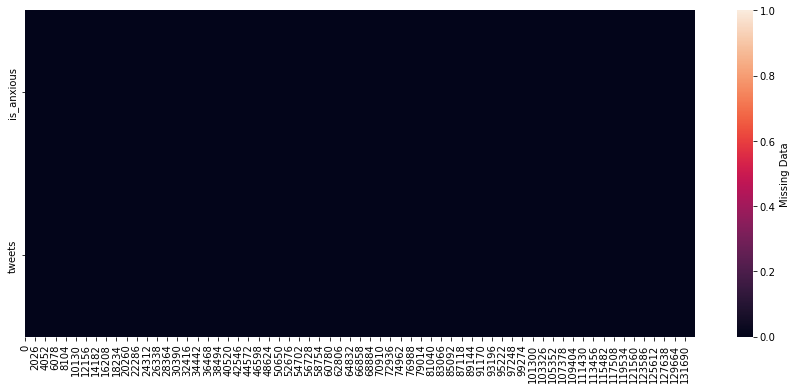

In [4]:
plt.figure(figsize=(15,6))
sns.heatmap(dataset.isnull().transpose(),cbar_kws={'label': 'Missing Data'})
#No missing values visible, Good data !

In [5]:
print(dataset[dataset['tweets'].isnull()].index)

Index([  3549,   6355,  11587,  14719,  17853,  31396,  32461,  34233,  40000,
        44016,  45124,  55451,  66090,  70009,  77484,  82541,  92314, 104963,
       107150, 114256, 121873, 122677, 125343, 133001],
      dtype='int64')


In [6]:
dataset.dropna(inplace=True)

In [7]:
nan_indices = dataset[dataset.isna().any(axis=1)].index
print(nan_indices)

Index([], dtype='int64')


In [8]:
X = dataset['tweets']
y = dataset['is_anxious']
X

0                                      home deal may happen
1                                would good time break rafa
2          feel like got hit baseball bat right back lovely
3         jchawes great luck flight j keep reminding air...
4         boo cant regular blood donation quotin waiting...
                                ...                        
133665    havent followed follower yet cuz goddamn mobil...
133666    say nitey nite twitterverse x im going stretch...
133667    ohya tweeter happy anniversary quick becom 8mn...
133668    useful science last banksy6 ha ha knew true ma...
133669    four hour duck red wing awesomeness completely...
Name: tweets, Length: 133646, dtype: object

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1,1), test_size=0.05, random_state=4)
len(X_train),len(X_test)

(126963, 6683)

In [ ]:
max_features_values = [10000, 15000, 20000]

tfidf_vectorizer = TfidfVectorizer()
 
param_grid = {
    'max_features': max_features_values,
}

grid_search = GridSearchCV(tfidf_vectorizer, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_max_features = grid_search.best_params_['max_features']

print(f"Best max_features: {best_max_features}")

best_tfidf_vectorizer = grid_search.best_estimator_

/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/Users/yben409/opt/anaconda3/lib/python3

Best max_features: 10000


In [11]:
pickle.dump(best_tfidf_vectorizer, open('grid_search_10000_tfidf.pkl', 'wb'))

In [10]:
best_tfidf_vectorizer = pickle.load(open('grid_search_10000_tfidf.pkl', 'rb'))

In [11]:
X_train_tweets_tfidf = best_tfidf_vectorizer.transform(X_train)
X_test_tweets_tfidf = best_tfidf_vectorizer.transform(X_test)

num_train_samples, _ = X_train_tweets_tfidf.shape
num_test_samples, _ = X_test_tweets_tfidf.shape

print(f"Number of training samples: {num_train_samples}")
print(f"Number of test samples: {num_test_samples}")

Number of training samples: 126963
Number of test samples: 6683


In [12]:
# Convert your sparse TF-IDF matrices to dense numpy arrays
X_train_tweets_dense = X_train_tweets_tfidf.toarray()
X_test_tweets_dense = X_test_tweets_tfidf.toarray()

In [13]:
nb = GaussianNB()
nb2 = BernoulliNB()
nb3 = MultinomialNB()
VotingClassifiers = VotingClassifier(estimators=[('GaussianNB', nb),('BernoulliNB',nb2), ('MultinomialNB', nb3)], voting='soft')

VotingClassifiers.fit(X_train_tweets_dense, y_train)

/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yben409/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


VotingClassifier(estimators=[('GaussianNB', GaussianNB()),
                             ('BernoulliNB', BernoulliNB()),
                             ('MultinomialNB', MultinomialNB())],
                 voting='soft')

In [14]:
print('Training score:', VotingClassifiers.score(X_train_tweets_dense, y_train))
print('Testing score:', VotingClassifiers.score(X_test_tweets_dense, y_test))

Training score: 0.7401447665855406
Testing score: 0.6916055663624121


In [15]:
import pickle
pickle.dump(VotingClassifiers, open('Voting_classifier_5.pkl', 'wb'))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=5, random_state=42)
rf_classifier.fit(X_train_tweets_dense, y_train)

In [ ]:
print('Training score:', rf_classifier.score(X_train_tweets_dense, y_train))
print('Testing score:', rf_classifier.score(X_test_tweets_dense, y_test))

In [ ]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(n_estimators=5, random_state=42)
y_train = np.where(y_train == 0, 0, 1)
xgb_classifier.fit(X_train_tweets_dense, y_train)

In [ ]:
print('Training score:', xgb_classifier.score(X_train_tweets_dense, y_train))
print('Testing score:', xgb_classifier.score(X_test_tweets_dense, y_test))

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier()
clf.fit(X_train_tweets_dense, y_train)

In [ ]:
print('Training score:', clf.score(X_train_tweets_dense, y_train))
print('Testing score:', clf.score(X_test_tweets_dense, y_test))